* colors: Number of colors

* C: number of classes

* A: actions {l:left, r:right, a:above, b:below}

* cube: adjacency matrix of the cube

### Challenges
* What and when to give rewards?

### Things that can go wrong:
* Stop gradient in the mean_actions
* Learning rate

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Build the cube adjancy matrix


In [2]:
cube = np.array([[1, 3, 4, 5], [2,0,4,5], [3,1,4,5], [0,2,4,5], [1,3,2,0], [3,1,2,0]], dtype=np.int32)

* generate a dataset
* Assume that we are generating 10 classes, with 10 colors in total

In [3]:
batch_size = 10
num_actions = 4
hid_dim = 10
gamma = 1
num_colors = 10
num_classes = batch_size
num_faces = 6
SMALL_NUM = 1e-10
initLr = 0.1
lrDecayRate = .995
lrDecayFreq = 500
momentumValue = .9

In [4]:
X = np.random.randint(num_colors, size=(batch_size, num_faces))
y = np.arange(num_classes)
# converting in one-hot representation
X_train = np.zeros((batch_size, num_faces, num_colors))
for i in range(batch_size):
    for j in range(num_faces):
        X_train[i, j, X[i, j]] = 1

# Make the y one-hot representation
y_train = np.zeros((batch_size, num_classes))
for i in range(batch_size):
    y_train[i, y[i]] = 1
X_train.astype(np.int32)
y_train.astype(np.int32)

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

In [5]:
X

array([[4, 6, 8, 8, 0, 9],
       [7, 7, 7, 4, 6, 7],
       [9, 9, 0, 8, 5, 1],
       [2, 9, 6, 0, 1, 3],
       [2, 7, 7, 0, 0, 8],
       [7, 1, 9, 8, 9, 1],
       [7, 8, 5, 3, 6, 8],
       [4, 6, 2, 7, 7, 0],
       [5, 4, 8, 5, 3, 3],
       [1, 7, 4, 4, 8, 0]])

* Define the computation graph

In [6]:
def get_kernel(kernel_shape, bias_shape):
    # Create variable named "weights".
    weights = tf.get_variable("weights", kernel_shape,
        initializer=tf.random_normal_initializer())
    # Create variable named "biases".
    biases = tf.get_variable("biases", bias_shape,
                             initializer=tf.random_normal_initializer())
    return weights, biases

In [7]:
def get_next_batch(x, init_view, actions, cube):
    """ Get the slice of the next input from the placeholder x
    given the next location (left, right, above, below) to look at.
    One thing to make sure that you need to first sample to face index
    from the cube adjagit remote add origin git@github.com:GodOfProbability/RL-for-shape.gitcency matrix, given the current face and the action
    taken.Init_views[901]
    : param x: complete data matrix, of shape: (batch_size, num_faces, num_colors)
    : param init_view: the current face indices in the batch_x
    : param actions: the action taken (l, r, a, b)
    : param cube: the cube data adjacency matrix.
    : return batch_x: the next_batch 
    """
#     init_view = tf.argmax(init_view, 1)
    init_view = tf.cast(init_view, dtype=tf.int32)
    size = [1, num_colors]
    batch_x = []
    face_indices = []
    for i in range(batch_size):
        # from actions, find the face index
        face_index = cube[init_view[i, 0], actions[i, 0]]
        face_indices.append(face_index)
        begin = [face_index, 0]
        z = tf.slice(x[i, :, :], begin=begin, size=size, name="z_slicing")
        z = tf.reshape(z, shape=[tf.shape(z)[-1]])
        batch_x.append(z)
    batch_x = tf.pack(batch_x, axis=0)
    face_indices = tf.pack(face_indices, axis=0)
    face_indices = tf.reshape(face_indices, shape = [tf.shape(face_indices)[0], 1])
    return batch_x, face_indices

def get_init_view(x, init_view):
    """Given the complete data matrix, give me the batch_x
    :param x: complete data matrix, of shape: (batch_size, num_faces, num_colors)
    :param init_view: the indices of the faces of the cube that 
    you see on the first time
    :return batch_x: the batch for learning of shape (batch_size x num_colors)
    the colors are represented in one-hot way.
    """

    size = [1, num_colors]
    batch_x = []
    for i in range(batch_size):
        begin = [init_view[i, 0], 0]
        z = tf.slice(x[i, :, :], begin=begin, size=size)
        z = tf.reshape(z, shape=[tf.shape(z)[-1]], name="z_slicing")
        batch_x.append(z)
    batch_x = tf.pack(batch_x, axis=0)
    return batch_x

In [8]:
# x = tf.constant(X_train)
# cubes = tf.constant(cube)
# initial_view = tf.constant(y_train[:, 0].reshape((10, 1)))
# actions = tf.constant([[1], [2], [3], [0], [1], [2], [3], [0], [2], [1]], dtype=tf.int32)
# batch_x, face_indices = get_next_batch(x, initial_view, actions, cubes)
# with tf.Session() as sess:
#     print (sess.run(face_indices).shape)

In [9]:
def model(cube):
    x = tf.placeholder(name="input_data", shape=[None, num_faces, num_colors], dtype=tf.float32) # total number of colors are 10 in one hot way
    y = tf.placeholder(name="labels", shape=[None, num_classes], dtype=tf.float32)
    cube = tf.constant(cube)
    REUSE = False
    COSTS = []
    Rewards = []
    accuracies = []
    initial_views = []
    # randomly generate first input view location.
    init_view = tf.random_uniform((batch_size, 1), minval=0, maxval=num_faces)
    init_view = tf.to_int32(init_view, name='ToInt32')
    hidden = tf.truncated_normal(shape=[batch_size, hid_dim], mean=0.0, stddev=0.1, dtype=tf.float32, seed=None, name=None)
    with tf.name_scope("init_view") as scope:
        batch_x = get_init_view(x, init_view)
    for i in range(6):
        print (i)
        initial_views.append(init_view)
        with tf.variable_scope("x_hidden", reuse=REUSE):
            W_x, _ = get_kernel(kernel_shape=[num_colors, hid_dim], bias_shape=[hid_dim])

        with tf.variable_scope("hidden_hidden", reuse=REUSE):
            W_h, b_h = get_kernel(kernel_shape=[hid_dim, hid_dim], bias_shape=[hid_dim])

        with tf.variable_scope("class", reuse=REUSE):
            W_c, b_c = get_kernel(kernel_shape=[hid_dim, num_classes], bias_shape=[num_classes])

        with tf.variable_scope("action", reuse=REUSE):
            W_a, b_a = get_kernel(kernel_shape=[hid_dim, num_actions], bias_shape=[num_actions])

        with tf.name_scope("x_to_hid") as scope:
            # Construct a linear model
            x_hidden = tf.matmul(batch_x, W_x)
        with tf.name_scope("hid_to_hid") as scope:
            h_hid = tf.matmul(hidden, W_h) + b_h
            
        with tf.name_scope("hidden_t") as scope:
            hidden = tf.sigmoid(x_hidden + h_hid)

        with tf.name_scope("classification") as scope:
            probs = tf.nn.softmax(tf.matmul(hidden, W_c) + b_c)  # Softmax prob for classes
        
        mean_actions = tf.nn.softmax(tf.matmul(hidden, W_a) + b_a)  # Softmax prob for actions
        
        # sample from these actions
        samp_action = tf.multinomial(mean_actions, 1,)
        samp_action = tf.cast(samp_action, dtype=tf.int32)
        tf.stop_gradient(samp_action) # Stop the gradient flowing from non-differential cube-view sampling
        
        # define the rewards
        max_p_y = tf.arg_max(probs, 1)
        max_y = tf.arg_max(y, 1)

        equals = tf.equal(max_p_y,max_y)
        equals = tf.cast(equals, tf.float32)
        acc = tf.reduce_mean(equals)
        
        R = equals
        R = tf.reshape(R, (batch_size, 1))
        
        # Loss function corresponding to the policy
        # I guess this is the probility of the action getting selected under softmax assumption
        with tf.name_scope("policy_gradient") as scope:
#             p_loc = tf].zeros_like(samp_action, dtype=tf.float32)
            p_loc = []
            for index in range(batch_size):
                p_loc.append(mean_actions[index, samp_action[index, 0]])
            p_loc = tf.pack(p_loc, axis=0)
            loss_p = tf.log(p_loc) * (R) * (gamma**i)
        # Loss function correponding to the class prediction
        with tf.name_scope("class_loss") as scope:
            # Minimize error using cross entropy, y is in one-hot representation
            loss_class = y * tf.log(probs)
            
        J = tf.concat(1, [loss_p, loss_class])
        J = tf.reduce_sum(J, 1)
        J = tf.reduce_mean(J, 0)

        cost = -J
        COSTS.append(cost)
        accuracies.append(acc)
        Rewards.append(R)

        with tf.name_scope("get_next_batch") as scope:
            batch_x, init_view = get_next_batch(x, init_view, samp_action, cube)

        # Don't use the initialized variable again
        REUSE = True
    COSTS = tf.reduce_sum(COSTS)
    reward = tf.reduce_mean(Rewards)
#     accuracy = tf.reduce_mean(accuracies)
    with tf.name_scope("train") as scope:
        # Gradient descent
        optimizer = tf.train.GradientDescentOptimizer(lr).minimize(COSTS)
    return x, y, COSTS, Rewards, accuracies, optimizer, initial_views, equals

In [10]:
tf.reset_default_graph()
global_step = tf.Variable(0, trainable=False, dtype=tf.int32)
lr = tf.train.exponential_decay(initLr, global_step, lrDecayFreq, lrDecayRate, staircase=True, )
x, y, costs, reward, acc, optimizer, initital_views, equals = model(cube)

0
1
2
3
4
5


Let us define few baseline experiments:
* The cube is not rotated and their is a fixed policy
* The cube is rotated and their is a fixed policy.
* The cube is not rotated and their is a random policy.
* The cube is rotated and their is a random policy.

In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    accuracies = []
    rewards = []
    Init_views = []
    COSTS = []
    for i in range(1000):
#         print (i)
        l = np.arange(batch_size)
        np.random.shuffle(l)
        X_train = X_train[l]
        y_train = y_train[l]
        acc_, reward_, _ = sess.run([acc, reward, optimizer], feed_dict={x:X_train, y:y_train})
        accuracies.append(acc_)
        rewards.append(reward_)
#         Init_views.append(initial_views)
#         COSTS.append(costs_)

In [12]:
accuracies[900:]

[[0.30000001, 0.60000002, 0.60000002, 0.89999998, 0.89999998, 0.70000005],
 [0.30000001, 0.80000001, 0.80000001, 0.89999998, 0.89999998, 0.89999998],
 [0.30000001, 0.60000002, 0.30000001, 0.5, 0.40000001, 0.60000002],
 [0.40000001, 0.30000001, 0.5, 0.5, 0.60000002, 0.60000002],
 [0.1, 0.2, 0.5, 0.80000001, 0.80000001, 0.70000005],
 [0.5, 0.5, 0.80000001, 0.89999998, 0.80000001, 0.89999998],
 [0.30000001, 0.60000002, 0.80000001, 0.60000002, 0.60000002, 0.70000005],
 [0.2, 0.40000001, 0.60000002, 0.80000001, 0.80000001, 0.70000005],
 [0.30000001, 0.70000005, 0.89999998, 0.70000005, 0.80000001, 0.80000001],
 [0.30000001, 0.5, 0.60000002, 0.80000001, 0.89999998, 0.89999998],
 [0.2, 0.40000001, 0.70000005, 0.80000001, 0.80000001, 0.70000005],
 [0.2, 0.60000002, 0.60000002, 0.70000005, 0.5, 0.60000002],
 [0.5, 0.30000001, 0.60000002, 0.5, 0.89999998, 0.70000005],
 [0.2, 0.69999999, 0.80000001, 0.70000005, 0.70000005, 0.60000002],
 [0.2, 0.60000002, 0.40000001, 0.70000005, 0.70000005, 0.60000

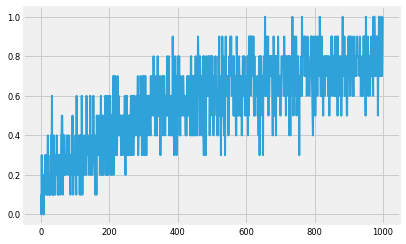

In [16]:
plt.figure(1)                # the first figure
plt_index = 160
for j in range(1):
    plot_x = []
    for i in range(len(accuracies)):
        plot_x.append(accuracies[i][5])
#     plt.subplot(plt_index)
    plt.plot(plot_x)

In [14]:
# with tf.Session() as sess:
#     v = tf.constant(value=np.zeros((10, 6, 10)))
# #     zero = tf.constant(np.arange(2))
# #     first = tf.constant(np.arange(10))
# #     last = tf.constant(np.arange(6))
# #     z = v[first, zero, last]
# #     indices = tf.constant(5)
# # #     zero = tf.constant(0)
# #     begin = tf.pack([indices, 0])
# #     shape_ = tf.constant([1, 10])
# #     zs = []
# #     for i in range(10):
# #         z = tf.slice(v[i, 1, :], begin=[indices, 0], size=[1, 10])
# #         shape_z = tf.shape(z)
# #         z = tf.reshape(z, shape=[shape_z[-1]])
# #         zs.append(z)
# #     tf.global_variables_initializer()
# #     zs = tf.pack(zs, axis=0)
#     l = tf.constant([1, 2, 3, 4, 5, 6, 7, 8, 9, 0])
#     zs = v[0, :, l]
#     print (sess.run(zs).shape)